In [1]:
import PyPDF2
import spacy
from spacy.en import English
from spacy import attrs
import numpy as np

parser = English()

In [2]:
pdfList = []
for i in range(1,26):
    pdfList.append(str(i)+".PDF")

text = []
for pdf in pdfList:
    with open(pdf, 'rb') as pdfFileObj:
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        for page in range(1,pdfReader.getNumPages()):
            pageObj = pdfReader.getPage(page)
            text.append(pageObj.extractText())

docTrain1 = ' '.join(text) #combine all pages into a String doc
print (len(docTrain1))

text = [] 
with open('HungerGames.pdf', 'rb') as pdfFileObj:
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    for page in range(1,pdfReader.getNumPages()):
        pageObj = pdfReader.getPage(page)
        text.append(pageObj.extractText())

with open('HarryPotter.pdf', 'rb') as pdfFileObj:
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    for page in range(1,pdfReader.getNumPages()):
        pageObj = pdfReader.getPage(page)
        text.append(pageObj.extractText())
        
docTrain0 = ' '.join(text) #combine all pages into a String doc
print (len(docTrain0))

1067102
1004314


In [3]:
parsedData = parser(docTrain1)

sents1 = []
for span in parsedData.sents:
    sent = ''.join(parsedData[i].string for i in range(span.start, span.end)).strip()
    sents1.append(sent)
print (len(sents1))

parsedData = parser(docTrain0)

sents0 = []
for span in parsedData.sents:
    sent = ''.join(parsedData[i].string for i in range(span.start, span.end)).strip()
    sents0.append(sent)
print (len(sents0))

8946
17310


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
import string
import re

# A custom stoplist
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve"]

In [5]:
# Every step in a pipeline needs to be a "transformer". 
# Define a custom transformer to clean text using spaCy
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
        
    def get_params(self, deep=True):
        return {}

# A custom function to clean the text before sending it into the vectorizer, called by Transformer
def cleanText(text):
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    
    # replace twitter @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("@MENTION", text)
    
    # replace HTML symbols
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")
    
    # lowercase
    text = text.lower()
    
    return text

# A custom function to tokenize the text using spaCy
# and convert to lemmas
def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    
    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    
    return tokens

In [6]:
# define training data
train = sents1+sents0

labelsTrain = []
for i in range(0,len(train)):
    if (i < len(sents1)):
        labelsTrain.append(1)
    else:
        labelsTrain.append(0)

In [27]:
# define test data
test = ["Plaintiffs failed to establish",
        "challenged statutes violate equal protection",
        "I just want to eat a hamburger", 
        "this is just another sentence", 
        "the quick brown fox jumped",
        "courts and statutes", 
        "over the lazy dog",
        "what time is the party",
        "what are my legal rights",
        "due process in civil court",
        "what time is it",
        "let's run to the park and have fun",
        "let's add come complexity to this sentence",
        "What would be a good test",
        "who in the world knows all about",
        "I will be getting home late today",
        "the plaintiff alleges that the defendant",
        "Three more sentences to go here",
        "let's hurry up so we can go home",
        "she went to court today and"]
labelsTest = [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

print (len(test))
print (len(labelsTest))

20
20


In [8]:
# the vectorizer and classifer to use
# note that I changed the tokenizer in CountVectorizer to use a custom function using spaCy's tokenizer
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,4))
lsa = TruncatedSVD(100, algorithm = 'randomized')
clf = LinearSVC()
# the pipeline to clean, tokenize, vectorize, and classify
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer),('clf', clf)])

In [9]:
# train
pipe.fit(train, labelsTrain)

Pipeline(steps=[('cleanText', <__main__.CleanTextTransformer object at 0x1808d66a0>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [28]:
# test
preds = pipe.predict(test)

for (sample, pred) in zip(test, preds):
    print(sample, ":", pred)

print("\n","Accuracy:", accuracy_score(labelsTest, preds))

Plaintiffs failed to establish : 1
challenged statutes violate equal protection : 1
I just want to eat a hamburger : 0
this is just another sentence : 0
the quick brown fox jumped : 0
courts and statutes : 1
over the lazy dog : 0
what time is the party : 0
what are my legal rights : 0
due process in civil court : 1
what time is it : 0
let's run to the park and have fun : 0
let's add come complexity to this sentence : 0
What would be a good test : 0
who in the world knows all about : 0
I will be getting home late today : 0
the plaintiff alleges that the defendant : 1
Three more sentences to go here : 0
let's hurry up so we can go home : 0
she went to court today and : 1

 Accuracy: 0.95


# GET TWITTER DATA

In [11]:
import pandas as pd
import tweepy
import json
import cnfg
from os.path import expanduser

home = expanduser("~")
config = cnfg.load(home + "/.twitter_config")

auth = tweepy.OAuthHandler(config["consumer_key"],
                           config["consumer_secret"])
auth.set_access_token(config["access_token"],
                      config["access_token_secret"])

api=tweepy.API(auth)

In [42]:
def structure_results(results, handle):
    id_list = [tweet.id for tweet in results]
    data = pd.DataFrame(id_list,columns=['id'])
    
    data["Handle"] = handle
    data["Text"] = [tweet.text for tweet in results]
    data["Datetime"] = [tweet.created_at for tweet in results]
    data["Location"] = [tweet.place for tweet in results]
    
    return data

# Replace https...with empty string
def httpRemove(text):
    if re.search('https?:\/\/.*[\r\n]*', text):
        return re.sub('https?:\/\/.*[\r\n]*', '', text).strip()
    else:
        return text

# Replace @.... with empty string
def atRemove(text):
    if re.search('@([\w.-]+)', text):
        return re.sub('@([\w.-]+)', '', text).strip()
    else:
        return text

# Replace #.... with empty string
def hashRemove(text):
    if re.search('#([\w.-]+)', text):
        return re.sub('#([\w.-]+)', '', text).strip()
    else:
        return text

def toPandas(userText, preds):
    id_list=[i for i in range(0,len(preds))]
    data=pd.DataFrame(id_list,columns=['tweet_id'])
    
    data["text"]= [tweet for tweet in userText]
    data["Prediction"] = [prediction for prediction in preds]

    return data

In [ ]:
import time
handles = ['NinaTotenberg', 'justinbieber', 'LeoDiCaprio', 'espn','EricHolder','Snowden','jimmykimmel','realDonaldTrump']
#handles = ['NinaTotenberg']

frames = []
for handle in handles:
    tweets = tweepy.Cursor(api.user_timeline,id=handle).items(1000)
    results = []
    print (handle)
    for tweet in tweets:
        results.append(tweet)
    
    data = structure_results(results, handle)
    frames.append(data)
    time.sleep(1)

In [132]:
alldata = pd.concat(frames)

In [133]:
alldata["text_no_https"] = alldata.Text.apply(httpRemove)

alldata["text_no_https_at"] = alldata.text_no_https.apply(atRemove)

alldata["text_no_https_at_hash"] = alldata.text_no_https_at.apply(hashRemove)

In [134]:
userText = []
for text in alldata.text_no_https_at_hash:
    userText.append(text)

In [135]:
# test
preds = pipe.predict(userText)

In [136]:
alldata['Prediction'] = [p for p in preds]

In [137]:
pd.set_option('max_colwidth', 120)

alldata['Rating'] = 0
for handle in alldata.Handle.unique():
    rating = alldata[alldata['Handle'] == handle].Prediction.sum()/alldata[alldata['Handle'] == handle].Prediction.count()
    print (handle, rating)
    alldata.loc[alldata['Handle'] == handle,'Rating'] = rating

NinaTotenberg 0.459357277883
justinbieber 0.173
LeoDiCaprio 0.178410794603
espn 0.258
EricHolder 0.337209302326


In [150]:
alldata.head()

,id,Handle,Text,Datetime,Location,text_no_https,text_no_https_at,text_no_https_at_hash,Prediction,Rating
0,738369861181546496,NinaTotenberg,"SG Donald Verrilli stepping down after 5 yrs of historic #SCOTUS arguments, from Obamacare to same-sex marriage. htt...",2016-06-02 14:01:07,None,"SG Donald Verrilli stepping down after 5 yrs of historic #SCOTUS arguments, from Obamacare to same-sex marriage.","SG Donald Verrilli stepping down after 5 yrs of historic #SCOTUS arguments, from Obamacare to same-sex marriage.","SG Donald Verrilli stepping down after 5 yrs of historic arguments, from Obamacare to same-sex marriage.",1,0.459357
1,737749855993466880,NinaTotenberg,Amid prickly dissents from right and left #SCOTUS weighs In on 2 death penalty cases https://t.co/4u11eqr8yI,2016-05-31 20:57:27,None,Amid prickly dissents from right and left #SCOTUS weighs In on 2 death penalty cases,Amid prickly dissents from right and left #SCOTUS weighs In on 2 death penalty cases,Amid prickly dissents from right and left weighs In on 2 death penalty cases,1,0.459357
2,737705151679598592,NinaTotenberg,SCOTUS declines to hear #Trump Resorts bankruptcy case that stripped workers of health insurance &amp; pension benef...,2016-05-31 17:59:48,None,SCOTUS declines to hear #Trump Resorts bankruptcy case that stripped workers of health insurance &amp; pension benef...,SCOTUS declines to hear #Trump Resorts bankruptcy case that stripped workers of health insurance &amp; pension benef...,SCOTUS declines to hear Resorts bankruptcy case that stripped workers of health insurance &amp; pension benefits.,1,0.459357
3,735550431049486336,NinaTotenberg,Are Justices #Alito and #Thomas sore losers? Interesting perspective: https://t.co/ibt0DLwUhw,2016-05-25 19:17:43,None,Are Justices #Alito and #Thomas sore losers? Interesting perspective:,Are Justices #Alito and #Thomas sore losers? Interesting perspective:,Are Justices and sore losers? Interesting perspective:,0,0.459357
4,735158217752346624,NinaTotenberg,Your legal affairs queen isn’t always serious. She’s also a dancing queen. https://t.co/1nHpqFdzPh @washingtonpost h...,2016-05-24 17:19:12,None,Your legal affairs queen isn’t always serious. She’s also a dancing queen.,Your legal affairs queen isn’t always serious. She’s also a dancing queen.,Your legal affairs queen isn’t always serious. She’s also a dancing queen.,0,0.459357


In [138]:
alldata.to_pickle('test')

In [145]:
idList = []
r = []
for handle in alldata.Handle.unique():
    print (handle, alldata[alldata['Handle'] == handle].Rating[0])
    
    idList.append(handle)
    r.append(alldata[alldata['Handle'] == handle].Rating[0])

smallDataframe = pd.DataFrame(idList,columns=['Handle'])
smallDataframe["Rating"] = r

NinaTotenberg 0.459357277883
justinbieber 0.173
LeoDiCaprio 0.178410794603
espn 0.258
EricHolder 0.337209302326


In [148]:
smallDataframe = smallDataframe.sort_values('Rating', ascending = False)
smallDataframe

,Handle,Rating
0,NinaTotenberg,0.459357
4,EricHolder,0.337209
3,espn,0.258000
2,LeoDiCaprio,0.178411
1,justinbieber,0.173000


In [149]:
smallDataframe.to_pickle('summary')

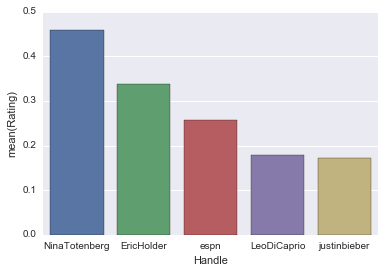

In [159]:
import seaborn as sns

sns.barplot(smallDataframe['Handle'],smallDataframe['Rating'])